**To do**
- get the nn to run on GPU
- run through a full run with the 100 patients (get longer timeout)
- run the experiments with full data
- add the nurse network modules

In [1]:
from env import data_dir

In [20]:
# Basic utilities
import importlib
import datetime
import json
import pickle
import math
import numpy as np
import pandas as pd
import itertools
from collections import OrderedDict
from tqdm import tqdm_notebook as tqdm
import logging
import argparse
import os
from pprint import pprint, pformat
from pathlib import Path

# Machine Learning
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *

# Basis Expansion (external package)
# from basis_expansions import (Binner, Polynomial, 
#                               LinearSpline, CubicSpline,
#                               NaturalCubicSpline)
# from dftransformers import ColumnSelector, FeatureUnion, Intercept, MapFeature

# Deep Learning
import torch
print("PyTorch Version:  {}".format(torch.__version__))
from torch import nn
import torch.nn.functional as F
import skorch
from skorch import NeuralNetRegressor
from skorch.callbacks import Callback

# Plotting and visualization
%matplotlib inline
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import HBox, Label, Layout
from IPython.display import display, clear_output
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

# Local files
import utils 
import dataloader
import nn_models
importlib.reload(utils)
importlib.reload(dataloader)
importlib.reload(nn_models)

torch.cuda.set_device(0)

print("Setup complete!")

PyTorch Version:  1.2.0
Setup complete!


In [21]:
params = utils.Params(
    {
        "output_type": "classification",  # Classification vs Regression
        "project_dir": Path.home()/'code'/'itan-nn',  # Top-level path for this project
        "data_dir": data_dir,  # Relative data path
        "cohort_file": data_dir/"cohort.h5",  # File path to the cohort dataset (hdf5)
        'hourly_file': data_dir/'hourly.tsv',
        "sample_dir": data_dir/'encounter_splits',  # Directory to the split patient hourly data
        "label": "LOS",  # Column name of target/label in cohort dataframe
        "cohort_features": ["ADM_LAPS2", "ADM_COPS2", "SEX", "AGE"],  # Which cohort-level features to use
#         "hourly_features": ["LAPS2"],#, "IMAR_IM_GROUP"],  # Which patient hourly features to use
        "hourly_features": ["LAPS2", "IMAR_IM_GROUP","IMAR_INH_GROUP", "IMAR_IVD_GROUP",
                            "IMAR_IVR_GROUP", "IMAR_MSC_GROUP", "IMAR_OR_GROUP",
                            "OT_A_GROUP", "OT_B_GROUP", "OT_D_GROUP", "OT_I_GROUP",
                            "OT_L_GROUP", "OT_N_GROUP"],  # Which patient hourly features to use
        "all_locations": ['OR', 'WARD', 'ICU', 'TCU', 'PAR'], # ICU, WARD, OR / 
        "pad_length": 96,  # maximum number of hours of each time-series to include
        "association_history": 0,  # How many hours to look back in unit occupancy to define patient associations
        "associated_time_max": 96,  # maximum number of hours to consider over all all associate patients
        "max_associated_patients": 200,  # maximum number of associated patients to consider over all time
        "max_occupancy": 150,  # maximum number of associated patients to consider in a unit at a single time
        "pad_value": 0,  # Value to pad variable-length input sequences with (unused), and to fill NaNs
        "hourly_embedding_fill_value": 0,  # Value to pad variable-length input sequences with (unused), and to fill NaNs
        "patient_hourly_hidden_size": 32,  # hidden size of LSTM output
        "unit_hourly_hidden_size1": 64,  # hidden size of LSTM output when merging patient hourly data over unit occupancy
        "unit_hourly_hidden_size2": 128,  # hidden size of LSTM output when accumulating unit embeddings over time
        "num_hourly_output_features": 32,  # hidden size of LSTM output
        "num_layers": 5,  # number of stacked LSTM layers (each with same hidden_size)
        "model_name": "itan_strain_classification_net",  # which model to train ('linear', 'lstm')
        "included_features": ["static", "hourly", "strain"],  # Whether to feed static, hourly, and/or strain features directly into the output layer
        "predict_remaining_LoS": True,  # Whether to predict remaining LoS instead of total LoS
        "predict_after_hours": 0,  # Number of hours to index the time series target and input.  0 to predict at every point.  use included_features parameter to restrict to static data
        "num_epochs": 100,  # number of training epochs.  Note:  can rerun the training cell if warm_start=True
        "batch_size": 10,  # number of samples per batch.  Usually limited by GPU memory.
        "learning_rate": 0.01,  # optimizer learning rate
        "dropout_prob": 0.0,  # dropout regularization probability (0 for not implemented)
        "cross_validation_ratios": {"train": 0.8, "val": 0.1, "test": 0.1},  # Fraction of data in each CV split
        "split_file": data_dir/"set_splits_1000.json",  # Where to save the CV splits
        "subset": 100,  # train/evaluate on a smaller subset of the data for testing purposes, reduced runtime
        'subset_facility': None,
        "torch_random_seed": 7532941,  # RNG seed for PyTorch (weight initialization and dataset shuffling per-epoch)
        "numpy_random_seed": 7532941,  # RNG seed for NumPy (randomly selecting among associated occupants at each hour)
        "normalize_cohort": True,  # Whether to normalize the cohort features (mean 0, std 1)
        "normalize_hourly": True,  # Whether to normalize the hourly features (mean 0, std 1), rolling computation over all sample IDs
    }
)

In [22]:
# Where to save trained weights, log files, parameter file, results, etc.
model_dir = os.path.join(params.project_dir, 'experiments/', params.model_name)

# Set the logger
utils.set_logger(os.path.join(model_dir, 'ITAN_Strain_RNN_Classification.log'), logging.INFO) #  DEBUG  INFO

# Save params to file
params.save(os.path.join(model_dir, 'params.json'))
logging.info("Parameters:\n{}".format(pformat(params.__dict__)))
logging.info("Parameters set and saved to file")

Parameters:
{'all_locations': ['OR', 'WARD', 'ICU', 'TCU', 'PAR'],
 'associated_time_max': 96,
 'association_history': 0,
 'batch_size': 10,
 'cohort_features': ['ADM_LAPS2', 'ADM_COPS2', 'SEX', 'AGE'],
 'cohort_file': '/home/jovyan/data/itan/cohort.h5',
 'cross_validation_ratios': {'test': 0.1, 'train': 0.8, 'val': 0.1},
 'data_dir': '/home/jovyan/data/itan',
 'dropout_prob': 0.0,
 'hourly_embedding_fill_value': 0,
 'hourly_features': ['LAPS2',
                     'IMAR_IM_GROUP',
                     'IMAR_INH_GROUP',
                     'IMAR_IVD_GROUP',
                     'IMAR_IVR_GROUP',
                     'IMAR_MSC_GROUP',
                     'IMAR_OR_GROUP',
                     'OT_A_GROUP',
                     'OT_B_GROUP',
                     'OT_D_GROUP',
                     'OT_I_GROUP',
                     'OT_L_GROUP',
                     'OT_N_GROUP'],
 'hourly_file': '/home/jovyan/data/itan/hourly.tsv',
 'included_features': ['static', 'hourly', 'strain'],


In [117]:
# Load sample IDs and set up dataset
cohort_df = pd.read_hdf(os.path.join(params.project_dir, params.data_dir, params.cohort_file),
                                      start=0, 
                                      stop=-1)
cohort_df.columns = [x.upper() for x in cohort_df.columns]

# Check CV Parameters
assert (sum([params.cross_validation_ratios[split] for split in params.cross_validation_ratios.keys()]) == 1), "Cross validation splits must sum to 1:\n{}".format(params.cross_validation_ratios)

# Split separately for each facility
all_facilities = list(cohort_df["FAC_ID"].unique())
all_facilities.sort()
cohort_df["CV_FAC_SPLIT"] = 'none'
# with tqdm(total=len(all_facilities), desc="Facilities") as t:
for facility in all_facilities:
    logging.info("Splitting patients for facility {}".format(facility))
    facility_df = cohort_df.loc[cohort_df["FAC_ID"] == facility, :]

    # Split indices for appropriate number/ratio of patients (not days) per split
    N_patients = len(facility_df)
    train_split_index = math.floor(N_patients * params.cross_validation_ratios["train"])
    val_split_index = train_split_index + math.floor(N_patients * params.cross_validation_ratios["val"])

    # Sort by admit date and find boundaries
    facility_df = facility_df.sort_values(["ADM_DATE"]).reset_index(col_fill='cohort_index')
    start_date = facility_df.loc[0, "ADM_DATE"]
    end_date = facility_df.loc[N_patients-1, "ADM_DATE"]
    train_boundary_date = facility_df.loc[train_split_index, "ADM_DATE"]
    val_boundary_date = facility_df.loc[val_split_index, "ADM_DATE"]


    # Assign to cross-validation splits
    cohort_df.loc[((cohort_df["FAC_ID"] == facility) &
                   (cohort_df["DISCH_DATE"] < train_boundary_date)), "CV_FAC_SPLIT"] = 'train'
    cohort_df.loc[((cohort_df["FAC_ID"] == facility) &
                   (cohort_df["ADM_DATE"] >= train_boundary_date) &
                   (cohort_df["DISCH_DATE"] < val_boundary_date)), "CV_FAC_SPLIT"] = 'val'
    cohort_df.loc[((cohort_df["FAC_ID"] == facility) &
                   (cohort_df["ADM_DATE"] >= val_boundary_date)), "CV_FAC_SPLIT"] = 'test'
#         t.update()

logging.info("\nCross-validation split counts:\n{}\n\nCross-validation split ratios:\n{}\n".format(
    cohort_df["CV_FAC_SPLIT"].value_counts(),
    cohort_df["CV_FAC_SPLIT"].value_counts() / len(cohort_df)))


# Restrict to samples with hourly data available
# hourly_sample_ids = [np.int64(f.split('.')[0].split('_')[-1])
#                      for f in os.listdir(os.path.join(params.project_dir, params.sample_dir))
#                      if f.endswith('.h5')]
hourly_sample_ids = [f.stem for f in (Path(params.project_dir)/params.sample_dir).rglob('[0-9]*.tab')]
logging.debug("Loaded {} hourly sample IDs:\n{}".format(len(hourly_sample_ids), hourly_sample_ids[:3]))
cohort_df = cohort_df.loc[cohort_df["ENCOUNTER_ID"].astype(np.int64).isin(hourly_sample_ids), :]
logging.debug("{} samples remaining after dropping samples which don't have hourly data\n".format(len(cohort_df)))

# Subset to a single facility
if params.subset_facility is not None:
    cohort_df = cohort_df.loc[(cohort_df["FAC_ID"] == params.subset_facility), :]
    logging.info("Subsetted to {} samples in facility {} only".format(len(cohort_df), params.subset_facility))

# Split to lists of integers for constructing Skorch datasets
cv_split_samples = {}
for split in ["train", "val", "test"]:
    logging.info("Building {} split sample IDs".format(split))
    
    # Select the matching cohort encount IDs
    samples_df = cohort_df.loc[(cohort_df["CV_FAC_SPLIT"] == split), ["ADM_DATE", "ENCOUNTER_ID"]]
    
    # Sort chronologically to maximize concurrency on subset
    samples_df.sort_values(by="ADM_DATE", ascending=True, inplace=True)
    logging.info("Sorted samples:\n{}".format(samples_df[:10]))
    
    # Format as integers for size/index speed
    cv_split_samples[split] = list(samples_df["ENCOUNTER_ID"].astype(np.int64).reset_index(drop=True))
    
    # Select a smaller subset of each split for quick code testing
    if params.subset > 0:
        cv_split_samples[split] = cv_split_samples[split][:params.subset]
    logging.info("{} split:  {} samples".format(split, len(cv_split_samples[split])))


# Save CV splits to file (for easier reload if using subsets, alternate datasets on different machines, etc.)
logging.info(f"Saving set splits to {params.split_file}")
with open(params.split_file, 'w') as f:
    json.dump(cv_split_samples, f, indent=4)

Splitting patients for facility DRV
Splitting patients for facility FRE
Splitting patients for facility FRS
Splitting patients for facility MAN
Splitting patients for facility MOD
Splitting patients for facility OAK
Splitting patients for facility RCH
Splitting patients for facility ROS
Splitting patients for facility RWC
Splitting patients for facility SAC
Splitting patients for facility SCH
Splitting patients for facility SFO
Splitting patients for facility SLN
Splitting patients for facility SRF
Splitting patients for facility SRO
Splitting patients for facility SSC
Splitting patients for facility SSF
Splitting patients for facility STR
Splitting patients for facility VAC
Splitting patients for facility VAL
Splitting patients for facility WCR

Cross-validation split counts:
train    429818
test      54426
val       51845
none       4176
Name: CV_FAC_SPLIT, dtype: int64

Cross-validation split ratios:
train    0.795569
test     0.100739
val      0.095962
none     0.007730
Name: CV_FA

In [23]:
# Load CV Splits from file
cv_split_samples = utils.load_dict_from_json(params.split_file)
logging.info("Loaded CV splits from {}".format(params.split_file))
for split in cv_split_samples:
    logging.info("{} split:  {} samples".format(split, len(cv_split_samples[split])))
    
# Set the PyTorch seed for shuffline and weight initialization reproducibility
torch.manual_seed(params.torch_random_seed)
np.random.seed(params.numpy_random_seed)


# Construct Skorch datasets for training
logging.info("Constructing Strain datasets for each cross-validation split.")
importlib.reload(dataloader) # reload DataSet class from local file dataloader.py
datasets = {}
trained_params = None # recompute the normalization coefficients on first pass over train set split
for split in ["train", "val"]:
    logging.info("\nBuilding dataset for {} split".format(split))
    datasets[split] = dataloader.ITANStrainDataset(cv_split_samples[split],
                                                   params,
                                                   mode=split,
                                                   trained_params=trained_params,
                                                   show_progress_bar=True)
    logging.info("{} split:  {} samples:\n{}\nX: {}\nY: {}".format(split, len(cv_split_samples[split]), cv_split_samples[split][:3], None, datasets[split].length_of_stay.shape))
    
    logging.info("LoS values:  {}:  mean {:.2f} +/- {:.2f}".format(
        datasets[split].length_of_stay.shape,
        np.mean(datasets[split].length_of_stay),
        np.std(datasets[split].length_of_stay)))  
    
    # Update list of cohort features with categorical expansion
    params.expanded_cohort_features = datasets[split].cohort_features
    
    # Save the normalization coefficients from the train set split
    if split == "train":
        trained_params = datasets[split].trained_params
#     break # skip validation dataset
logging.info("\nDatasets defined!")

Loaded CV splits from /home/jovyan/data/itan/set_splits_1000.json
train split:  100 samples
val split:  100 samples
test split:  100 samples
Constructing Strain datasets for each cross-validation split.

Building dataset for train split
Pre-loading all cohort features
Loaded cohort data:  (100, 5)
               LOS  ADM_LAPS2  ADM_COPS2 SEX  AGE
ENCOUNTER_ID                                     
316197798405  1.09         96         22   M   84
316197799432  1.97         55         28   M   64
318165946376  1.88         34        108   F   70
312216207370  2.09         89         49   M   89
312216204811  0.95         40          9   M   54
Pre-loading all hourly features
Global time indices over 545 hours:  type <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
DatetimeIndex(['2015-11-01 03:00:00', '2015-11-01 04:00:00',
               '2015-11-01 05:00:00', '2015-11-01 06:00:00',
               '2015-11-01 07:00:00'],
              dtype='datetime64[ns]', freq='H')
Dropping rows 

In [26]:
model.device

'cpu'

In [25]:
next(model.parameters()).is_cuda

AttributeError: 'NeuralNetRegressor' object has no attribute 'parameters'

In [ ]:
# Select a model to train
importlib.reload(nn_models)  # reload nn.Module class from local file model.py

nn_module = nn_models.ITANStrainNetworkModule

# Choose model output type
if params.output_type == "regression":
    nn_loss = nn_models.MSELossMasked
elif params.output_type == "classification":
    nn_loss = nn_models.CrossEntropyLossMasked
else:
    logging.warning("Unknown output_type:  {}".format(self.params.output_type))
    raise NotImplementedError
    
# Add progress bar over batches within epoch to training
callbacks = [
    skorch.callbacks.PrintLog()
]

# NN Regression setup.  Construct model with preset parameters
net = NeuralNetRegressor(
    nn_module(params),
    criterion=nn_loss,
    max_epochs=params.num_epochs,
    lr=params.learning_rate,
    batch_size=params.batch_size,
    callbacks=callbacks,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
    verbose=1,
    warm_start=True,
)

model = net
logging.info("Model defined!")

# Fit the model
logging.info("Fitting model...")
model.fit(datasets["train"], y=None)
logging.info("Fit complete!")

Model defined!
Fitting model...


In [6]:
# # Continue fitting the model
# logging.info("Fitting model...")
# model.fit(datasets["train"], y=None)
# logging.info("Fit complete!")

Fitting model...


    101        0.0015        0.0015  2203.2816


Fit complete!


In [7]:
# Evaluate the trained model at multiple lengths of elapsed LoS
logging.info("Datasets:  {}".format(list(datasets.keys())))

max_hours = params.pad_length
hour_range = np.arange(0, max_hours)
auprc_train = np.zeros(max_hours)
auprc_val = np.zeros(max_hours)

logging.info("Running inferences for train split...")
all_y_train_pred = model.predict(datasets["train"])
logging.info("Running inferences for validation split...")
all_y_val_pred = model.predict(datasets["val"])
logging.info("Inferences complete!")

for pi, predict_after in enumerate(hour_range):
    # Compute metrics for train split
    # Note:  NN predicts LogSoftmax probability estimates
    y_train = datasets["train"].target[:, predict_after, 0]
    y_train_pred = np.exp(all_y_train_pred[:, predict_after, 0])
#     logging.info("y_train  {}:\n{}".format(y_train.shape, y_train))
#     logging.info("y_train_pred  {}:\n{}".format(y_train_pred.shape, y_train_pred))
    auprc_train[pi] = average_precision_score(y_train, y_train_pred)

    # Compute metrics for validation split
    y_val = datasets["val"].target[:, predict_after, 0]
    y_val_pred = np.exp(all_y_val_pred[:, predict_after, 0])
    auprc_val[pi] = average_precision_score(y_val, y_val_pred)

logging.info("Evaluation complete!")

Datasets:  ['train', 'val']
Running inferences for train split...
Running inferences for validation split...
Inferences complete!
Evaluation complete!


Max hours:   96
Hour range:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74
 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]
AUPRC (tr):  [ 0.2408082   0.27188204  0.28507261  0.29137803  0.32657378  0.37997131
  0.41898802  0.47515247  0.48611363  0.53378924  0.48372189  0.53995621
  0.51940946  0.54223878  0.51802235  0.57178527  0.54344556  0.5382074
  0.55954381  0.57657299  0.56306218  0.58053736  0.58803437  0.60369146
  0.61727106  0.62217033  0.64713984  0.65649234  0.66643864  0.68467
  0.68626135  0.69445092  0.69015843  0.69164246  0.68775686  0.68802063
  0.6952441   0.68475657  0.67657237  0.67649179  0.67889964  0.67859152
  0.67298425  0.67446348  0.66934653  0.68559224  0.69158988  0.69254314
  0.69846887  0.69773148  0.69902625  0.70615022  0.72006709  0.72222972
  0.72765661

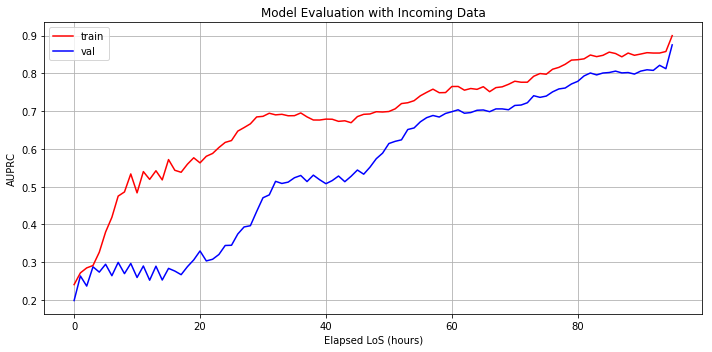

In [8]:
plot_stop = max_hours
logging.info("Max hours:   {}".format(max_hours))
logging.info("Hour range:  {}".format(hour_range))
logging.info("AUPRC (tr):  {}".format(auprc_train))


# Plot results for evaluation with variable inputs
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5), squeeze=False)

# Plot AUPRC over elapsed LoS
axes[0, 0].plot(hour_range[:plot_stop], auprc_train[:len(hour_range)][:plot_stop], color='red', label='train')
axes[0, 0].plot(hour_range[:plot_stop], auprc_val[:len(hour_range)][:plot_stop], color='blue', label='val')
axes[0, 0].set_ylabel("AUPRC")
axes[0, 0].set_title("Model Evaluation with Incoming Data")
axes[0, 0].set_xlabel("Elapsed LoS (hours)")
axes[0, 0].legend(loc='upper left')
axes[0, 0].grid(True)

fig.savefig("RNN_class_evaluation_over_time_alldata{}.png".format(plot_stop), tight_layout=True)

Evaluating after 96 hours
Training targets  (shape (997,)):  0.88+/-0.33, from min 0.00 to max 1.00
Training predictions  (shape (997,)):  1.00+/-0.00, from min 0.99 to max 1.00
Training AP:  0.90
Training AUROC:  0.60
/Users/daniel/anaconda/envs/python3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


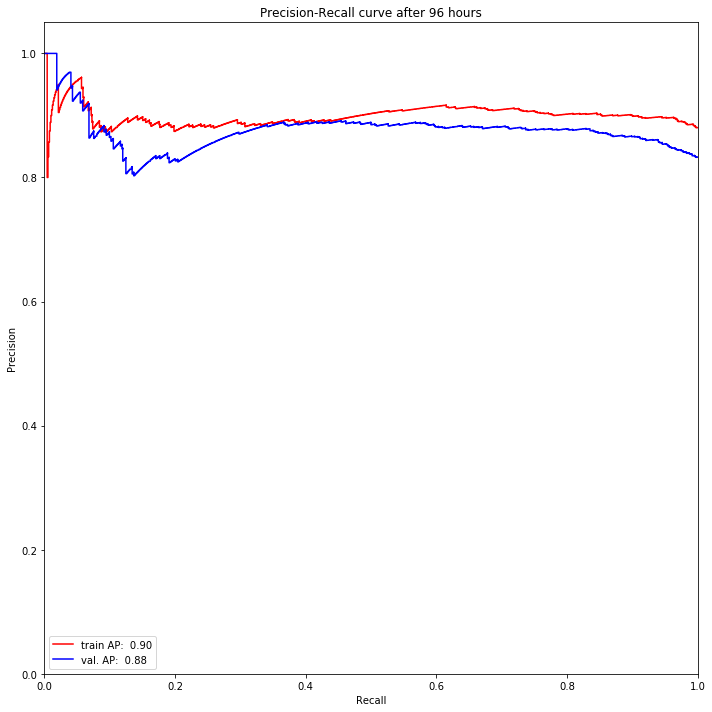

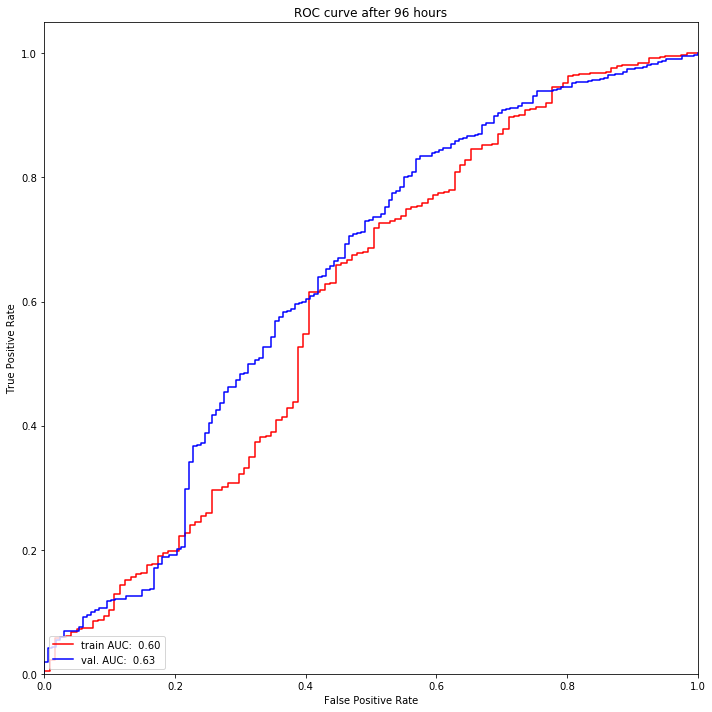

In [30]:
# Plot the Precision-Recall curve at selected number of elapsed hours
predict_after = 96#params.pad_length
logging.info("Evaluating after {} hours".format(predict_after))
y_train = datasets["train"].target[:, predict_after-1, 0]
y_train_pred = np.exp(all_y_train_pred[:, predict_after-1, 0])
ap_train = average_precision_score(y_train, y_train_pred)
auroc_train = roc_auc_score(y_train, y_train_pred)

logging.info("Training targets  (shape {}):  {:.2f}+/-{:.2f}, from min {:.2f} to max {:.2f}".format(
    y_train.shape, np.mean(y_train), np.std(y_train), np.min(y_train), np.max(y_train)))
logging.info("Training predictions  (shape {}):  {:.2f}+/-{:.2f}, from min {:.2f} to max {:.2f}".format(
    y_train_pred.shape, np.mean(y_train_pred), np.std(y_train_pred), np.min(y_train_pred), np.max(y_train_pred)))
logging.info("Training AP:  {:.2f}".format(ap_train))
logging.info("Training AUROC:  {:.2f}".format(auroc_train))


y_val = datasets["val"].target[:, predict_after-1, 0]
y_val_pred = np.exp(all_y_val_pred[:, predict_after-1, 0])
ap_val = average_precision_score(y_val, y_val_pred)
auroc_val = roc_auc_score(y_val, y_val_pred)


train_precision, train_recall, train_thresholds = precision_recall_curve(y_train, y_train_pred)
val_precision, val_recall, val_thresholds = precision_recall_curve(y_val, y_val_pred)

from inspect import signature
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10), squeeze=False)
# axes[0, 0].step(recall, precision, color='b', alpha=0.2, where='post')
# axes[0, 0].fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
axes[0, 0].step(train_recall, train_precision, color='red', label="train AP:  {:.2f}".format(ap_train))
axes[0, 0].step(val_recall, val_precision, color='blue', label="val. AP:  {:.2f}".format(ap_val))
axes[0, 0].set_xlabel('Recall')
axes[0, 0].set_ylabel('Precision')
axes[0, 0].set_ylim([0.0, 1.05])
axes[0, 0].set_xlim([0.0, 1.0])
axes[0, 0].legend(loc='lower left')
axes[0, 0].set_title('Precision-Recall curve after {} hours'.format(predict_after))
fig.savefig("RNN_class_prc_{}hr.png".format(predict_after), tight_layout=True)


train_fpr, train_tpr, _ = roc_curve(y_train, y_train_pred)
val_fpr, val_tpr, _ = roc_curve(y_val, y_val_pred)


fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10), squeeze=False)
# axes[0, 0].step(recall, precision, color='b', alpha=0.2, where='post')
# axes[0, 0].fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
axes[0, 0].step(train_fpr, train_tpr, color='red', label="train AUC:  {:.2f}".format(auroc_train))
axes[0, 0].step(val_fpr, val_tpr, color='blue', label="val. AUC:  {:.2f}".format(auroc_val))
axes[0, 0].set_xlabel('False Positive Rate')
axes[0, 0].set_ylabel('True Positive Rate')
axes[0, 0].set_ylim([0.0, 1.05])
axes[0, 0].set_xlim([0.0, 1.0])
axes[0, 0].legend(loc='lower left')
axes[0, 0].set_title('ROC curve after {} hours'.format(predict_after))
fig.savefig("RNN_class_roc_{}hr.png".format(predict_after), tight_layout=True)

Evaluating over all hours
Training targets  (shape (95712,)):  0.59+/-0.49, from min 0.00 to max 1.00
Training predictions  (shape (95712,)):  1.00+/-0.00, from min 0.96 to max 1.00
Training AP:  0.69
Training AUROC:  0.64
/Users/daniel/anaconda/envs/python3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


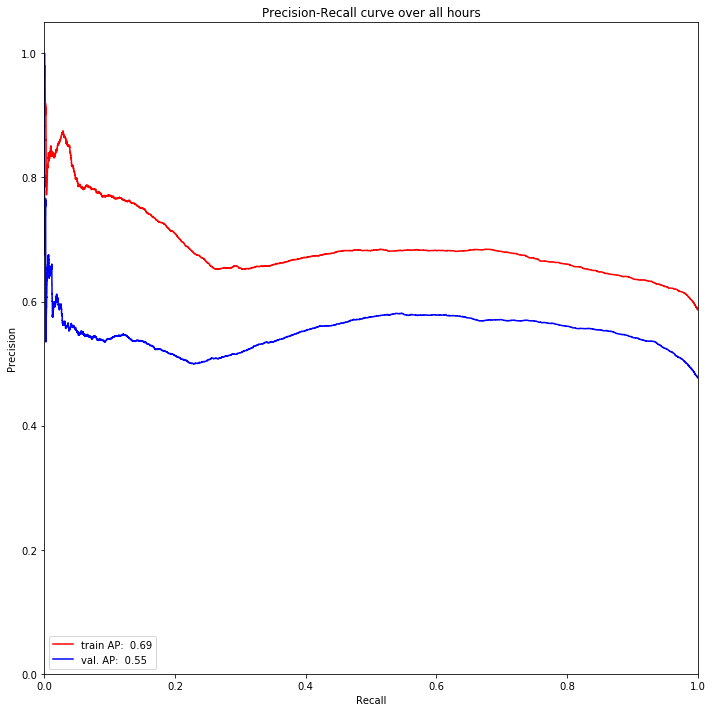

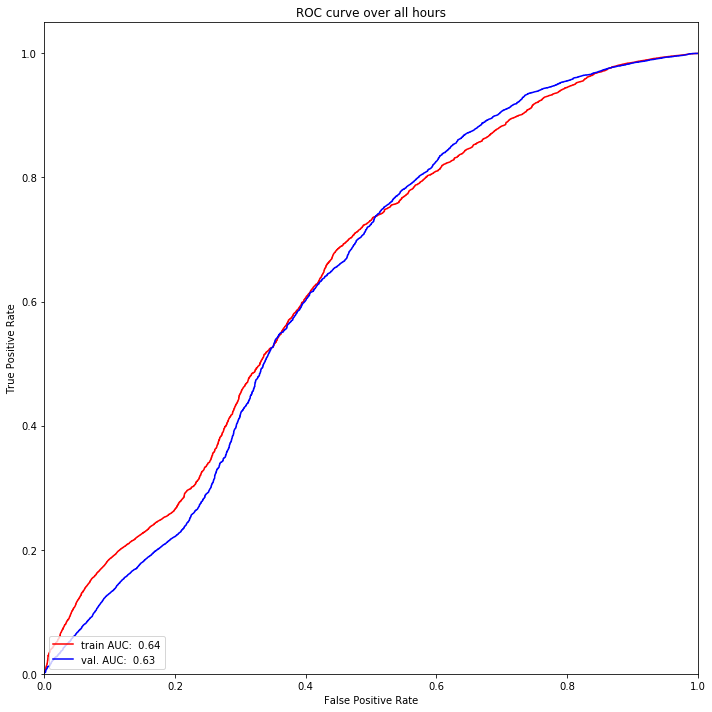

In [31]:
# Plot the Precision-Recall curve over all elapsed hours independently
logging.info("Evaluating over all hours")
y_train = datasets["train"].target[:, :, 0].flatten()
y_train_pred = np.exp(all_y_train_pred[:, :, 0].flatten())
ap_train = average_precision_score(y_train, y_train_pred)
auroc_train = roc_auc_score(y_train, y_train_pred)

logging.info("Training targets  (shape {}):  {:.2f}+/-{:.2f}, from min {:.2f} to max {:.2f}".format(
    y_train.shape, np.mean(y_train), np.std(y_train), np.min(y_train), np.max(y_train)))
logging.info("Training predictions  (shape {}):  {:.2f}+/-{:.2f}, from min {:.2f} to max {:.2f}".format(
    y_train_pred.shape, np.mean(y_train_pred), np.std(y_train_pred), np.min(y_train_pred), np.max(y_train_pred)))
logging.info("Training AP:  {:.2f}".format(ap_train))
logging.info("Training AUROC:  {:.2f}".format(auroc_train))


y_val = datasets["val"].target[:, :, 0].flatten()
y_val_pred = np.exp(all_y_val_pred[:, :, 0].flatten())
ap_val = average_precision_score(y_val, y_val_pred)
auroc_val = roc_auc_score(y_val, y_val_pred)


train_precision, train_recall, train_thresholds = precision_recall_curve(y_train, y_train_pred)
val_precision, val_recall, val_thresholds = precision_recall_curve(y_val, y_val_pred)

from inspect import signature
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10), squeeze=False)
# axes[0, 0].step(recall, precision, color='b', alpha=0.2, where='post')
# axes[0, 0].fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
axes[0, 0].step(train_recall, train_precision, color='red', label="train AP:  {:.2f}".format(ap_train))
axes[0, 0].step(val_recall, val_precision, color='blue', label="val. AP:  {:.2f}".format(ap_val))
axes[0, 0].set_xlabel('Recall')
axes[0, 0].set_ylabel('Precision')
axes[0, 0].set_ylim([0.0, 1.05])
axes[0, 0].set_xlim([0.0, 1.0])
axes[0, 0].legend(loc='lower left')
axes[0, 0].set_title('Precision-Recall curve over all hours')
fig.savefig("RNN_class_prc_all_hr.png", tight_layout=True)


train_fpr, train_tpr, _ = roc_curve(y_train, y_train_pred)
val_fpr, val_tpr, _ = roc_curve(y_val, y_val_pred)


fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10), squeeze=False)
# axes[0, 0].step(recall, precision, color='b', alpha=0.2, where='post')
# axes[0, 0].fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
axes[0, 0].step(train_fpr, train_tpr, color='red', label="train AUC:  {:.2f}".format(auroc_train))
axes[0, 0].step(val_fpr, val_tpr, color='blue', label="val. AUC:  {:.2f}".format(auroc_val))
axes[0, 0].set_xlabel('False Positive Rate')
axes[0, 0].set_ylabel('True Positive Rate')
axes[0, 0].set_ylim([0.0, 1.05])
axes[0, 0].set_xlim([0.0, 1.0])
axes[0, 0].legend(loc='lower left')
axes[0, 0].set_title('ROC curve over all hours')
fig.savefig("RNN_class_roc_all_hr.png", tight_layout=True)